#  **Spatial Gaussian Process on Albedo Data**




In [1]:
# import commonly used packages
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## **Intro to the NetCDF**

The netCDF (Network Common Data Format) is a multidimensional data file format used for storing weather and climate data. For this analysis there are two netcdf files, one for each of two GOES satellites (GOES 075 and GOES 135) corresponding to July 1, 2000. These GOES satellites are placed at different angles with respect to the earth's surface of the Americas that they are recording. Notice that, because of this, they do not cover the same areas, but there is substantial overlap. The files are large, they take 156 MB. The data contains information on albedo, the proportion of the incident light or radiation that is reflected by a surface, over the region of the Americas.

`xarray` is a package for working with N-dimensional data that natively supports NetCDF files.

In [2]:
!pip install xarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import xarray as xr

In [4]:
# load data using xarray
file_path = '/content/GSA_AlbedoProd_GOES_075_VIS02_2000_181.nc'
data = xr.open_dataset(file_path)

## **NetCDF MetaData**

The core function of NetCDF files is to store arrays. These arrays may have one dimension (e.g time) or two dimensions (e.g. latitude and longitude), or more. NetCDF files often have three kinds of information:

*   **Dimensions:** The dimensions information in a NetCDF shows how many elements are spanned by each dimension. 

*   **Variables:** The arrays themselves, containing the data you want. Each array has an order of dimensions. For a two-dimensional array, the first dimension corresponds to the rows and the second dimension to the columns.

*   **Attribute:** Documentation information associated with either individual variables or the file as a whole (“global attributes”). Each attribute has a name (e.g. product_name) and text context (e.g. Global Surface Albedo)





In [5]:
data

<xarray.Dataset>
Dimensions:               (line: 5043, pixel: 4402)
Dimensions without coordinates: line, pixel
Data variables: (12/25)
    BHRiso                (line, pixel) float32 ...
    DHR30                 (line, pixel) float32 ...
    OverallQuality        (line, pixel) float32 ...
    NumSolutions          (line, pixel) float32 ...
    InputSlots            (line, pixel) float32 ...
    InputSlotsASM         (line, pixel) float32 ...
    ...                    ...
    Error_Tau             (line, pixel) float32 ...
    AOTAvgValue           (line, pixel) float32 ...
    StdErrAOTAvgValue     (line, pixel) float32 ...
    Radiom_RelError       (line, pixel) float32 ...
    latitude              (line, pixel) float32 ...
    longitude             (line, pixel) float32 ...
Attributes: (12/45)
    Year:                      2000
    day_in_year_start:         181
    day_in_year_end:           181
    product_generation_time:   1163442342
    netcdf_generation_time:    1170611002
    product_name:              Global Surface Albedo
    ...                        ...
    nominal_ssp:               -75.0
    avg_ssp_lat:               0.0
    avg_ssp_lon:               0.0
    avg_probability:           0.0
    avg_dhr30:                 0.0
    avg_dhr20_err:             0.0

## **Accessing Albedo Data**
Albedo is denoted as the variable `BHRiso` in netCDF file. Other variables of interest are `latitude` and `longitude`.



In [6]:
# data.<var> extracts variable information not content
data.BHRiso

<xarray.DataArray 'BHRiso' (line: 5043, pixel: 4402)>
[22199286 values with dtype=float32]
Dimensions without coordinates: line, pixel
Attributes:
    units:      p.n.
    long_name:  Albedo Product BHRiso
    valid_min:  0
    valid_max:  254

In [7]:
# data.<var> extracts variable content
# notice the DataArray is masked
data.BHRiso.load()

<xarray.DataArray 'BHRiso' (line: 5043, pixel: 4402)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Dimensions without coordinates: line, pixel
Attributes:
    units:      p.n.
    long_name:  Albedo Product BHRiso
    valid_min:  0
    valid_max:  254

In [8]:
# subset data by variables of interest
data = data[['BHRiso', 'latitude', 'longitude']]
data

<xarray.Dataset>
Dimensions:    (line: 5043, pixel: 4402)
Dimensions without coordinates: line, pixel
Data variables:
    BHRiso     (line, pixel) float32 nan nan nan nan nan ... nan nan nan nan nan
    latitude   (line, pixel) float32 ...
    longitude  (line, pixel) float32 ...
Attributes: (12/45)
    Year:                      2000
    day_in_year_start:         181
    day_in_year_end:           181
    product_generation_time:   1163442342
    netcdf_generation_time:    1170611002
    product_name:              Global Surface Albedo
    ...                        ...
    nominal_ssp:               -75.0
    avg_ssp_lat:               0.0
    avg_ssp_lon:               0.0
    avg_probability:           0.0
    avg_dhr30:                 0.0
    avg_dhr20_err:             0.0

In [9]:
# get the 'data' variables by using .fillna() & filling the mask with nan's
data = data.fillna(np.nan)

## **Restrict to a Region**

If you already know your region of interest you can subset you DataArray with `xarray.where` 

In [10]:
# latitude boundaries
lat_bounds = np.logical_and(data.latitude > -8, data.latitude < 15)
# longitude boundaries
lon_bounds = np.logical_and(data.longitude > -90, data.longitude < -60)
# boundary box
lat_lon_bounds = np.logical_and(lat_bounds, lon_bounds)
# restricting data to boundary box 
# (keep everything that falls in lat_lon_bounds)
region_dat = data.where(lat_lon_bounds, np.nan)

## **Create Pandas Data Frame**

In order to have the data in a workable pandas dataframe format, we can use `xarray.to_dataframe`

In [11]:
# convert data to a pandas frame
df = region_dat.to_dataframe()
df = df.dropna()
df = df.reset_index()

In [12]:
# sanity check on the dimensions
print('Dimensions: ', df.shape)
print('DataFrame:', df.head(), sep = '\n')

Dimensions:  (244583, 5)
DataFrame:
   line  pixel    BHRiso  latitude  longitude
0  1993   2340  0.035433 -7.994102 -69.991493
1  1993   2429  0.039370 -7.990644 -71.619133
2  1993   2548  0.039370 -7.988101 -73.788979
3  1993   2549  0.043307 -7.988099 -73.807190
4  1993   2553  0.039370 -7.988044 -73.880051


In [13]:
# drop variables line and pixel
df = df.drop(['line','pixel'], axis = 1)
print(df.head())

     BHRiso  latitude  longitude
0  0.035433 -7.994102 -69.991493
1  0.039370 -7.990644 -71.619133
2  0.039370 -7.988101 -73.788979
3  0.043307 -7.988099 -73.807190
4  0.039370 -7.988044 -73.880051


## **Remove Ocean Points**

In [14]:
!pip install global-land-mask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.7 MB/s 


In [15]:
# only focus on land masses
from global_land_mask import globe

In [16]:
landmass_region = df.loc[globe.is_land(df['latitude'], df['longitude'])]
print('Dimensions: ', landmass_region.shape)
print('DataFrame:', landmass_region.head(), sep = '\n')

Dimensions:  (162026, 3)
DataFrame:
     BHRiso  latitude  longitude
0  0.035433 -7.994102 -69.991493
1  0.039370 -7.990644 -71.619133
2  0.039370 -7.988101 -73.788979
3  0.043307 -7.988099 -73.807190
4  0.039370 -7.988044 -73.880051


## **Graph Full Albedo Data**

In [17]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 361 kB 7.5 MB/s 


In [18]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 864 kB 7.4 MB/s 
     |████████████████████████████████| 6.3 MB 35.1 MB/s 
     |████████████████████████████████| 30.5 MB 2.2 MB/s 
     |████████████████████████████████| 46 kB 2.2 MB/s 


In [19]:
import gpytorch
import torch
from mpl_toolkits.basemap import Basemap

In [20]:
full_data = torch.Tensor(landmass_region.to_numpy())

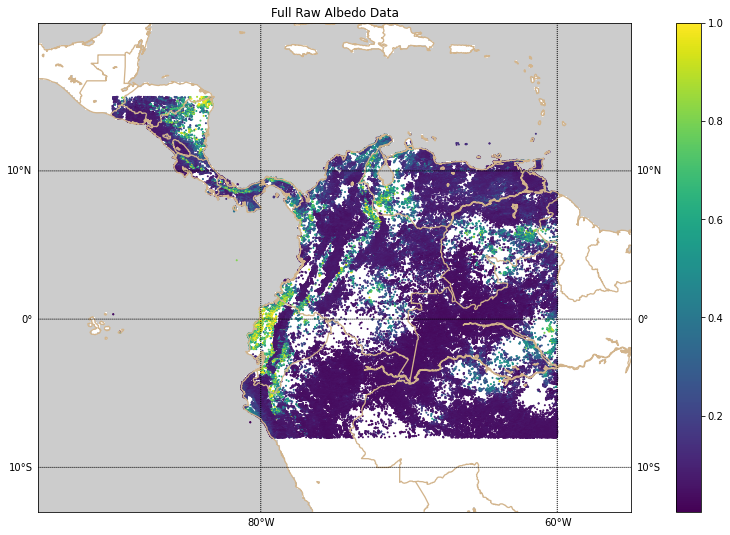

In [21]:
fig, ax = plt.subplots(figsize=(16, 9), ncols = 1)

# setup map projection.
m = Basemap(projection='cyl', resolution='i',\
            llcrnrlat=-8-5, urcrnrlat=15+5,\
            llcrnrlon=-90-5, urcrnrlon=-60+5)

# set up map cosmetics
m.drawlsmask(land_color='white', ocean_color='0.8', resolution='i')
m.drawcoastlines(color='tan', linewidth=1.3)
m.drawcountries(color='tan', linewidth=1.3)

# draw parallels and meridians
m.drawparallels(np.arange(-20,20,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,20),labels=[1,1,0,1])

# plot albedo data
ax.set_title('Full Raw Albedo Data')
plt.scatter(full_data[:,2].cpu(), full_data[:,1].cpu(),\
            s = 1, c = full_data[:,0].cpu())
plt.colorbar()
plt.show()

## **Train/Test Split of Data**

In [22]:
# order is BHRiso, latitude, longitude
full_data[:10,:]

tensor([[ 3.5433e-02, -7.9941e+00, -6.9991e+01],
        [ 3.9370e-02, -7.9906e+00, -7.1619e+01],
        [ 3.9370e-02, -7.9881e+00, -7.3789e+01],
        [ 4.3307e-02, -7.9881e+00, -7.3807e+01],
        [ 3.9370e-02, -7.9880e+00, -7.3880e+01],
        [ 5.1181e-02, -7.9880e+00, -7.3898e+01],
        [ 3.9370e-02, -7.9879e+00, -7.4263e+01],
        [ 3.9370e-02, -7.9877e+00, -7.4845e+01],
        [ 5.5118e-02, -7.9877e+00, -7.4991e+01],
        [ 3.9370e-02, -7.9877e+00, -7.5155e+01]])

In [23]:
# latitude, longitude
full_x = full_data[:,1:]
# BHRiso
full_y = full_data[:,0]

In [24]:
# sanity check
print('BHRiso:', full_y[:10])
print('(lat,lon):\n', full_x[:10,:])

BHRiso: tensor([0.0354, 0.0394, 0.0394, 0.0433, 0.0394, 0.0512, 0.0394, 0.0394, 0.0551,
        0.0394])
(lat,lon):
 tensor([[ -7.9941, -69.9915],
        [ -7.9906, -71.6191],
        [ -7.9881, -73.7890],
        [ -7.9881, -73.8072],
        [ -7.9880, -73.8801],
        [ -7.9880, -73.8983],
        [ -7.9879, -74.2625],
        [ -7.9877, -74.8452],
        [ -7.9877, -74.9909],
        [ -7.9877, -75.1548]])


In [25]:
# create training/test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(full_x,full_y,test_size=0.2, random_state = 1)

# move to GPU if available
if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()
else:
    train_x, train_y, test_x, test_y = X_train, y_train, X_test, y_test

## **Stochastic Variational GP Regression**
We'll be implementing a Stochatic Variational GP Regression following the documention in [GPyTorch](https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html) as reference.

### **Batches of Train/Test**

In [26]:
# Create DataLoader to run minibatches
from torch.utils.data import TensorDataset, DataLoader

# We have a lot of data so we use many batches of smaller data
n_batch_size =1000
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=n_batch_size, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=n_batch_size, shuffle=False)

In [27]:
# observations in each batch
print('Obs per batch:',len(train_loader))

Obs per batch: 130


### **Creating a SVGP Model**

We will need to construct the following GPyTorch objects:

* A GP Model (`gpytorch.models.ApproximateGP`)
* A Variational distribution (`gpytorch.variational._VariationalDistribution`) 
* A Variational strategy (`gpytorch.variational._VariationalStrategy`)

The `ApproximateGP` model is GPyTorch’s simplest approximate inference model. It approximates the true posterior with a distribution specified by a `VariationalDistribution`. Here, we use a `VariationalStrategy` with `learn_inducing_points=True`, and a `CholeskyVariationalDistribution`. These are the most straightforward and common options.

In [32]:
import tqdm
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [33]:
# this is the same as before but now 'automated'
class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, train_x, train_y, n_inducing_points = None):
        # if no number of inducing points specified
        inducing_length = (int(np.rint(train_x.shape[0]*0.5)))
        inducing_indexes = np.sort(np.random.choice(train_x.shape[0], size = n_inducing_points, replace=False))
        inducing_points = train_x[inducing_indexes, :]
        
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [34]:
# this is for running the notebook in our testing framework
num_epochs = 4


# Our testing script takes in a GPyTorch MLL (objective function) class
# and then trains/tests an approximate GP with it on the supplied dataset

def train_and_test_approximate_gp(model_cls):
    model = model_cls(train_x, train_y, n_inducing_points=100)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.numel())
    # replace mll with the following if using PPGPR
    # mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_y.numel())

    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    # Training
    model.train()
    likelihood.train()
    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc=f"Training {model_cls.__name__}")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            epochs_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()

    # Testing
    model.eval()
    likelihood.eval()
    means = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch)
            means = torch.cat([means, preds.mean.cpu()])
    means = means[1:]
    error = torch.mean(torch.abs(means - test_y.cpu()))
    print(f"Test {model_cls.__name__} MAE: {error.item()}")
    return means

In [35]:
means = train_and_test_approximate_gp(StandardApproximateGP)

Training StandardApproximateGP:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Test StandardApproximateGP MAE: 0.06022152304649353


In [36]:
means

tensor([0.0707, 0.0796, 0.0497,  ..., 0.0956, 0.0694, 0.1289])

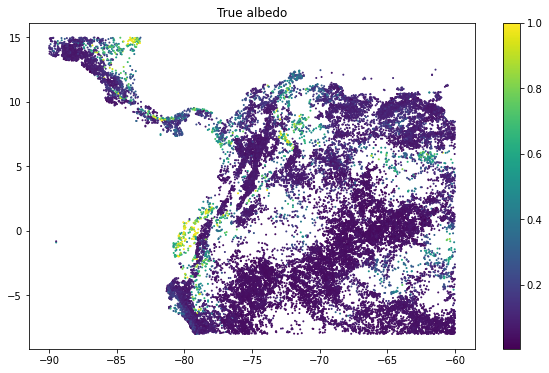

In [41]:
fig, ax = plt.subplots(figsize=(10, 6), ncols=1)
plt.scatter(test_x[:,1].cpu(), test_x[:,0].cpu(), s = 1,c=test_y.cpu())
ax.set_title('True albedo')
plt.colorbar()
plt.show()

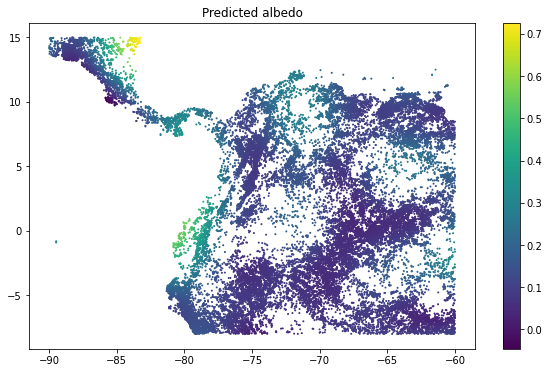

In [40]:
fig, ax = plt.subplots(figsize=(10, 6), ncols=1)
plt.scatter(test_x[:,1].cpu(), test_x[:,0].cpu(), s = 1,c=means.cpu())
ax.set_title('Predicted albedo')
plt.colorbar()
plt.show()

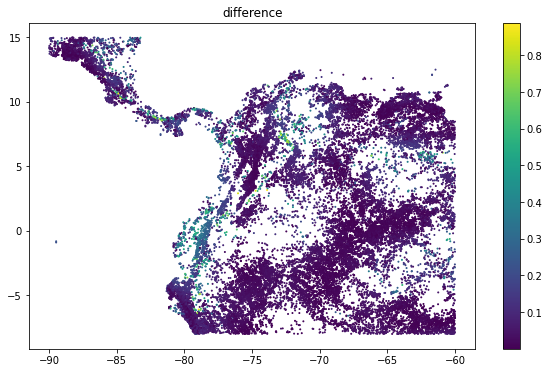

In [42]:
error = np.abs(means.cpu() - test_y.cpu())

fig, ax = plt.subplots(figsize=(10, 6), ncols=1)
plt.scatter(test_x[:,1].cpu(), test_x[:,0].cpu(), s = 1,c=error)
ax.set_title('difference')
plt.colorbar()
plt.show()